# EX1_Q3 - Obs Tech
Avraham Binnenfeld

### Funcs & Imports

In [40]:
import astropy as ap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
from astropy.coordinates import EarthLocation
from astropy.coordinates import get_moon
from astropy.coordinates import SkyCoord
from astropy.coordinates import get_moon
from astropy.coordinates import get_sun
from astropy.coordinates import AltAz
import astropy.coordinates as coord
from astropy import units as u
from astropy.time import Time

In [42]:
wise = EarthLocation.from_geodetic(30.597294, 34.762206)
wise.geodetic  

GeodeticLocation(lon=<Longitude 30.597294 deg>, lat=<Latitude 34.762206 deg>, height=<Quantity -1.16865037e-09 m>)

Array funcs

In [43]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

Random sky sampling funcs

In [44]:
def random_point_on_unit_sphere():
    while True:
        R   = np.random.rand(3)
        R   = 2*R - 1
        rsq = sum(R**2)
        if rsq < 1: break       
    return R / np.sqrt(rsq)     

def random_point_on_sky():
    p     = random_point_on_unit_sphere()
    r     = np.linalg.norm(p)
    theta = 90 - (np.arccos(p[2] / r)    / np.pi * 180)
    phi   =       np.arctan(p[1] / p[0]) / np.pi * 180
    c     = SkyCoord(ra=2*phi, dec=theta, unit=(u.degree, u.degree))
    return c

def print_random_star_coords(nstars):
    res = []
    for n in range(nstars):
        c = random_point_on_sky()
        res.append(c)
    return res

Point validity check

In [45]:
global glob_sum
glob_sum = 0

def is_point_ok(point):
    global glob_sum 
#     print(glob_sum)
    glob_sum = glob_sum + 1

    min_alt = 30 
    thresh_20 = 20
    
    # High galactic latitude (b >20°)
    if point.galactic.b.degree < thresh_20:
        return False
    
    # High ecliptic latitude (>20°)
    if point.geocentrictrueecliptic.lat.degree < thresh_20:
        return False
        
    utcoffset = 2 # UTC time offset in Israel (daylight saving)
    midnight_of_first_obs_night = Time('2021-3-1 00:00:00') # March 1st, survey starts
    delta_next_night = np.linspace(0, 90, 91)*u.day # ~~ 3 months
    survey_time = midnight_of_first_obs_night + delta_next_night
    
    x_reso = 100
    
    # Check observation window in every observation night
    for t_mid in survey_time:
        
        delta_midnight = np.linspace(-12, 12, x_reso)*u.hour
        daily_times = t_mid + delta_midnight
        
        # Calc darkness time
        frame_daily_times = AltAz(obstime=daily_times, location=wise)
        sunaltazs_daily_times = get_sun(daily_times).transform_to(frame_daily_times)
        a, b = find_nearest([m.alt.degree for m in sunaltazs_daily_times][:int(x_reso / 2)], 0)
        c, d = find_nearest([m.alt.degree for m in sunaltazs_daily_times][int(x_reso / 2):], 0)
        d = int(x_reso / 2 + d)
    
        sunset = t_mid - 12*u.hour + 24 / x_reso * b * u.hour + utcoffset*u.hour
        sunrise = t_mid - 12*u.hour + 24 / x_reso * d * u.hour + utcoffset*u.hour
        
        # Split darkness time into sampled time stamps
        zzz = pd.DatetimeIndex(np.linspace(pd.Timestamp(str(sunset)).value,
                                     pd.Timestamp(str(sunrise)).value, 50, dtype=np.int64))
        zzz = [Time(z) for z in zzz]
        
        # Calc point location at those times
        frame_July13night = AltAz(obstime=zzz, location=wise)
        m33altazs_July13night = point.transform_to(frame_July13night)
                
        # Calc moon location at those points
        moon_July12_to_13 = get_moon(Time(zzz))
        moonaltazs_July12_to_13 = moon_July12_to_13.transform_to(frame_July13night)
        
        dark_unit = np.abs((sunset - sunrise) * 24) / 50
        
        # Calc available observation time
        on_sky_time = np.sum((np.abs(moonaltazs_July12_to_13.alt.degree) > thresh_20) *
                             (np.abs(m33altazs_July13night.alt.degree) > min_alt) * dark_unit)
#         print(np.abs(m33altazs_July13night.alt.degree) > min_alt)
                  
        if on_sky_time < 1:
            print("----- short!")
            return False        
    
    # If point was not ruled out in any of the criteria - it is survey valid
    return True

### Test script

In [46]:
x = print_random_star_coords(1500)

----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!
----- short!

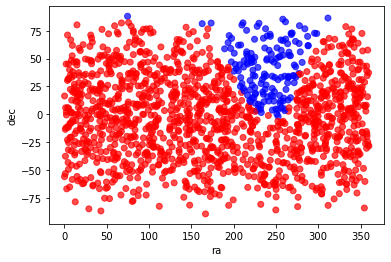

In [47]:
# Test validity and plot
res = [(x0.ra.degree, x0.dec.degree, is_point_ok(x0)) for x0 in x]
plt.scatter([x0[0] for x0 in res], [x0[1] for x0 in res], alpha=0.7, color=["blue" if x0[2] else "red" for x0 in res]) 
plt.xlabel("ra")
plt.ylabel("dec")
plt.show()

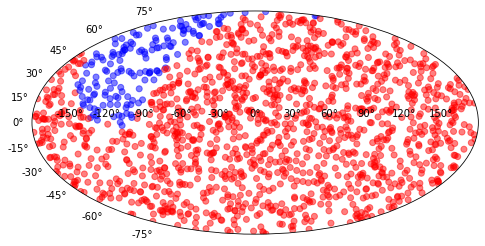

In [50]:
ra = coord.Angle([x0[0] for x0 in res]*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle([x0[1] for x0 in res]*u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian, color=["blue" if x0[2] else "red" for x0 in res], alpha=0.5)